In [1]:
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt

from probability import *
from hilbert_transform import *
from spectral_transforms import *
from numerical import *
from plotting import *

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

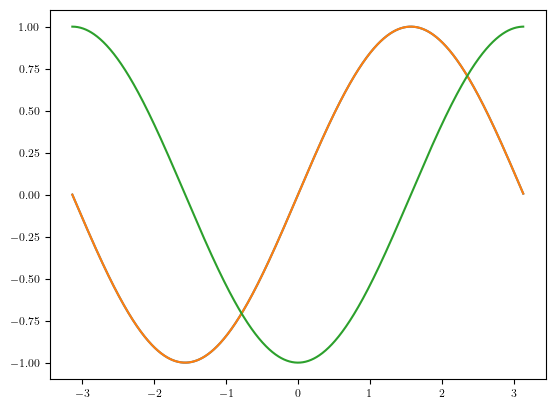

In [13]:
xs, _ = fourier_quad(-np.pi, np.pi, 1000)
us = np.cos(1*xs) #np.exp(-3*xs**2)

H0 = fourier_hilbert_transform(us, xs)
H1 = continuous_periodic_hilbert_transform(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H2 = continuous_periodic_hilbert_transform_v2(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H3 = continuous_periodic_hilbert_transform_v3(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H4 = continuous_periodic_hilbert_transform_v4(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H5 = continuous_periodic_hilbert_transform_v5(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))

plt.plot(xs, H0(xs))
plt.plot(xs, H1(xs))
#plt.plot(xs, 2*H2(xs))
#plt.plot(xs, H3(xs))
#plt.plot(xs, H4(xs))
plt.plot(xs, H5(xs))
plt.show()

#ys = xs#, _ = fourier_quad(-np.pi, np.pi, 10000)
#plt.plot(ys, H1(ys))
#plt.plot(ys, H2(ys))
#plt.show()

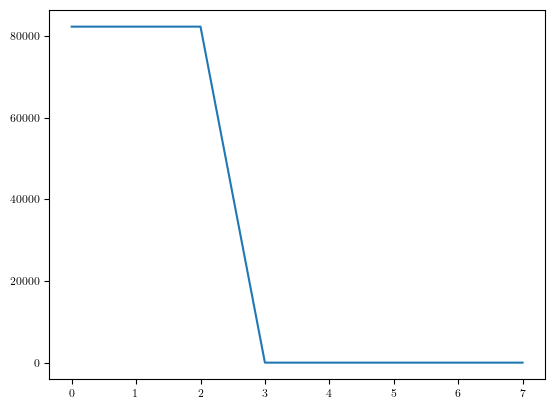

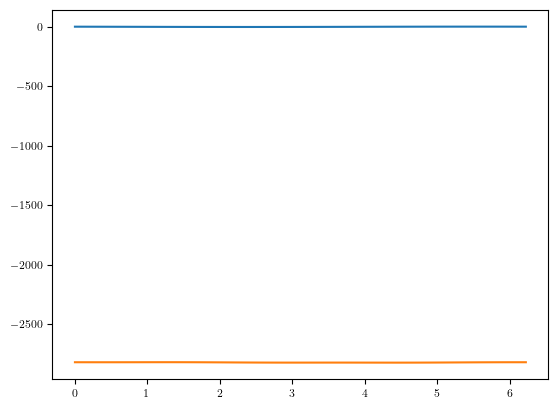

In [ ]:
periodic_domain = (-np.pi, np.pi)
zs = np.exp(2*np.pi*1j*(xs - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))
pol, res, _, _, _, _ = aaa(us, zs, max_terms=100)

plt.plot(np.abs(pol))
plt.show()

in_circle = np.abs(pol) < 1
f = lambda x: (np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1) - np.sum(res[~in_circle] / (x[:, None] - pol[~in_circle]), axis=1))/2
Hu = lambda x: -4*np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))


in_circle = np.abs(pol) < 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1)
Hu = lambda x: -2*np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))

'''
in_circle = np.abs(pol) >= 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1)
Hu = lambda x: np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))
'''

in_circle = np.abs(pol) < 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - 1/pol[in_circle]), axis=1)
Hu = lambda x: np.real(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))

plt.plot(xs, H0(xs))
plt.plot(xs, Hu(xs))
plt.show()

In [69]:
#us_hat = np.sum(res/(zs[:, None] - pol), axis=1)
def aaa_eval(zs, zj, fj, wj):
    with np.errstate(divide='ignore', invalid='ignore'):
        C = 1.0 / (zs[:,None] - zj[None,:])
        r = C.dot(wj*fj) / C.dot(wj)

    # for z in zj, the above produces NaN; we check for this
    nans = np.nonzero(np.isnan(r))[0]
    for i in nans:
        # is xv[i] one of our nodes?
        nodeidx = np.nonzero(zs[i] == zj)[0]
        if len(nodeidx) > 0:
            # then replace the NaN with the value at that node
            r[i] = fj[nodeidx[0]]
    return r

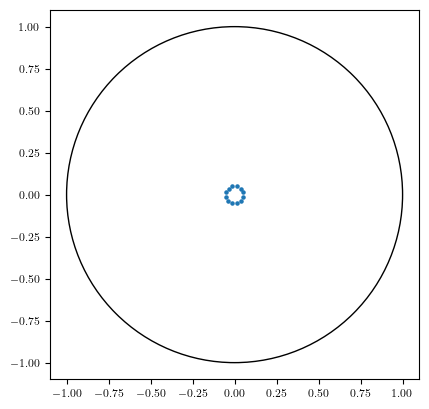

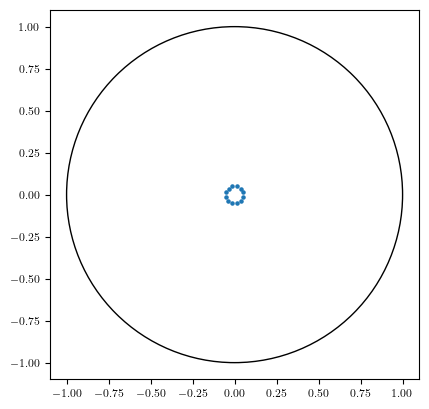

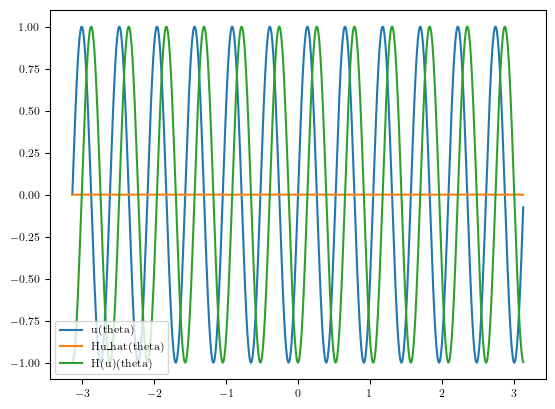

In [ ]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
zs = np.exp(1j*xs)
us = np.sin(12*xs) #np.cos(5*xs)
pol, _, _, _, _, _ = aaa(us, zs, max_terms=100)

fig, ax = plt.subplots()
ax.scatter(np.real(pol), np.imag(pol), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

in_circle = np.abs(pol) < 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[in_circle]), np.imag(pol[in_circle]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

thresh = 1e-5
at_origin = np.abs(pol) < thresh
k = np.sum(at_origin)

new_pol = pol[~at_origin]

d = np.min(np.abs(new_pol[:, None] - zs), axis=1)
A = d / (zs[:, None] - new_pol)
A = np.column_stack((np.power(1/zs[:, None], np.arange(1, k+1)), A))
A = np.concatenate([np.real(A), -np.imag(A)], axis=1)
c = np.reshape(np.linalg.lstsq(A, us, rcond=None)[0], (-1, 2), order='F') @ np.array([1, 1j])

f = lambda x: np.sum((c[k:]*d) / (x[:, None] - pol), axis=1) + np.sum(c[:k]/np.power(x[:, None], np.arange(1, k+1)), axis=1)
Hu = lambda x: -np.imag(f(np.exp(1j*x)))

H1 = continuous_periodic_hilbert_transform(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))

H = fourier_hilbert_transform(us, xs)

plt.plot(xs, us, label="u(theta)")
plt.plot(xs, Hu(xs), label="Hu_hat(theta)")
plt.plot(xs, H(xs), label="H(u)(theta)")
plt.legend()
plt.show()

In [111]:
from sklearn.linear_model import Ridge

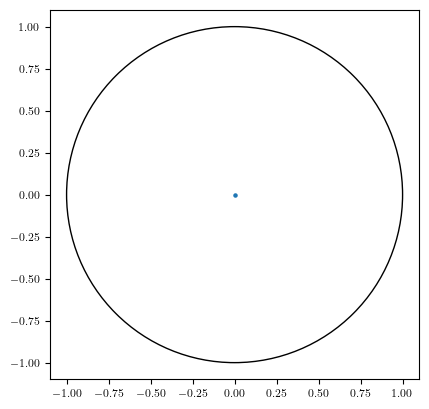

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [ ]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
zs = np.exp(1j*xs)
us = np.cos(xs) #np.sin(12*xs) + np.cos(5*xs) + np.sin(50*xs)
pol, _, _, _, _, _ = aaa(us, zs, max_terms=100)

out_circle = np.abs(pol) > 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[~out_circle]), np.imag(pol[~out_circle]), marker='o', s=5)
ax.scatter(np.real(pol[out_circle]), np.imag(pol[out_circle]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

H = fourier_hilbert_transform(us, xs)

ks = np.arange(500)
real_errs = np.zeros_like(ks, dtype=np.float64)
imag_errs = np.zeros_like(ks, dtype=np.float64)
conds = np.zeros_like(ks, dtype=np.float64)
for i in range(len(ks)):
    print(i)
    k = ks[i]
    
    if np.sum(out_circle) == 0 and k == 0:
        real_errs[i] = np.linalg.norm(us, ord=np.inf)
        imag_errs[i] = np.linalg.norm(H(xs), ord=np.inf)
        conds[i] = np.nan
    else:
        d = np.ones(np.sum(out_circle)) #np.min(np.abs(new_pol[:, None] - zs), axis=1)
        A = d / (zs[:, None] - pol[out_circle])
        A = np.column_stack((np.power(zs[:, None], np.arange(k)), A))
        A = np.concatenate([np.real(A), -np.imag(A)], axis=1)
        c = np.linalg.lstsq(A, us, rcond=None)[0]
        #clf = Ridge(alpha=100, fit_intercept=False).fit(A, us)
        #c = clf.coef_
        c = np.reshape(c, (-1, 2), order='F') @ np.array([1, 1j])

        f = lambda x: np.sum((c[k:]*d) / (x[:, None] - pol[out_circle]), axis=1) + np.sum(c[:k]*np.power(x[:, None], np.arange(k)), axis=1)
        u = lambda x: np.real(f(np.exp(1j*x)))
        Hu = lambda x: np.imag(f(np.exp(1j*x)))
    
        real_errs[i] = np.linalg.norm(us - u(xs), ord=np.inf)
        imag_errs[i] = np.linalg.norm(H(xs) - Hu(xs), ord=np.inf)
        conds[i] = np.linalg.cond(A)

plt.plot(ks, real_errs)
plt.show()

plt.plot(ks, imag_errs)
plt.show()

plt.plot(xs, us, label="u(theta)")
plt.plot(xs, u(xs))
plt.plot(xs, Hu(xs), label="Hu_hat(theta)")
plt.plot(xs, H(xs), label="H(u)(theta)")
plt.legend()
plt.show()

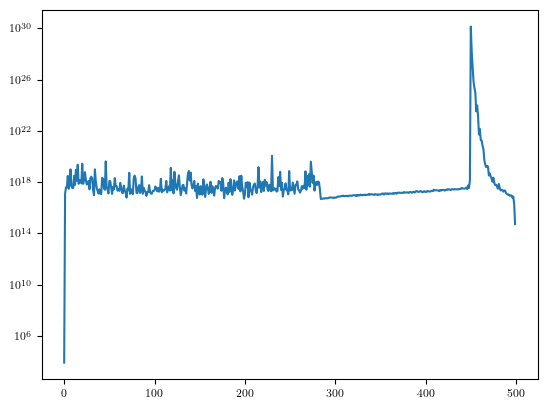

In [119]:
plt.plot(ks, conds)
plt.yscale("log")
plt.show()

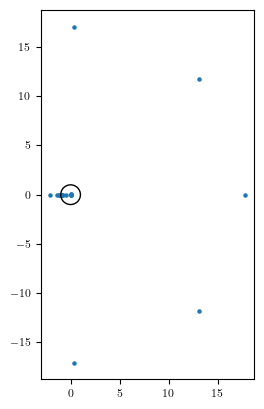

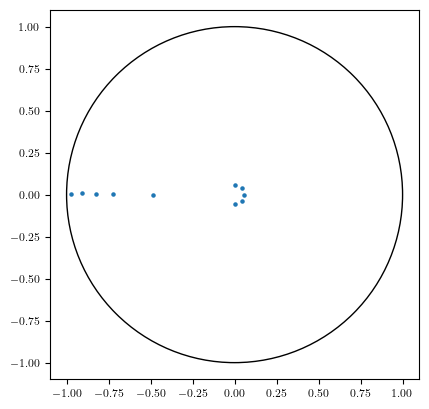

[ 3.52520145e-01-1.70708117e+01j  3.35364418e-01+1.70798823e+01j
  1.30140964e+01-1.17837365e+01j  1.30037467e+01+1.17983099e+01j
  1.76961245e+01+8.24897298e-03j -2.05716843e+00-4.91597700e-03j
  1.20917731e-03-5.85545169e-02j  4.22229314e-02-3.82311739e-02j
  5.65095080e-02+2.63136814e-05j  4.21792208e-02+3.82691944e-02j
  1.14919202e-03+5.85258465e-02j -1.38103517e+00+5.15663672e-03j
 -4.86101934e-01-1.16146429e-03j -1.21131192e+00+7.86212852e-03j
 -7.24085149e-01+2.70334531e-03j -8.25517796e-01+5.35756877e-03j
 -1.10172208e+00+8.32728470e-03j -9.07619844e-01+6.85969457e-03j
 -9.72049362e-01+6.63899023e-03j -1.02870819e+00+7.02616454e-03j]
[ 3.96035299e+02-5.77024819e+02j  3.91521510e+02+5.80092651e+02j
 -1.17387697e+03-4.37758574e+03j -1.20241663e+03+4.36735003e+03j
 -7.87844863e+03-2.44485602e+01j  1.34473017e-05+1.00414007e-07j
  1.27557059e+00+2.03365281e+00j -1.37559188e+01-5.19575186e+00j
  2.51585886e+01-5.45643890e-02j -1.37210736e+01+5.25553941e+00j
  1.26253040e+00-2.03887

In [43]:
fig, ax = plt.subplots()
ax.scatter(np.real(pol), np.imag(pol), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

circle_inds = np.abs(pol) < 1
fig, ax = plt.subplots()
ax.scatter(np.real(pol[circle_inds]), np.imag(pol[circle_inds]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

print(pol)
print(res)

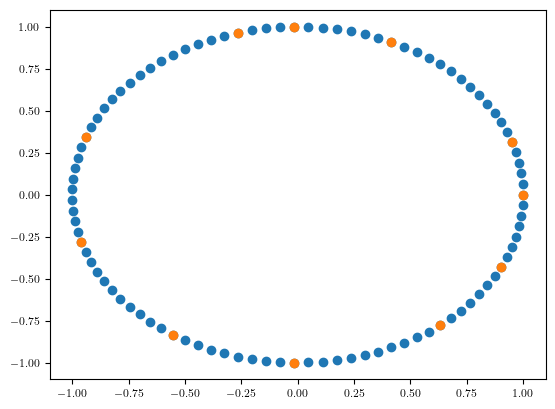

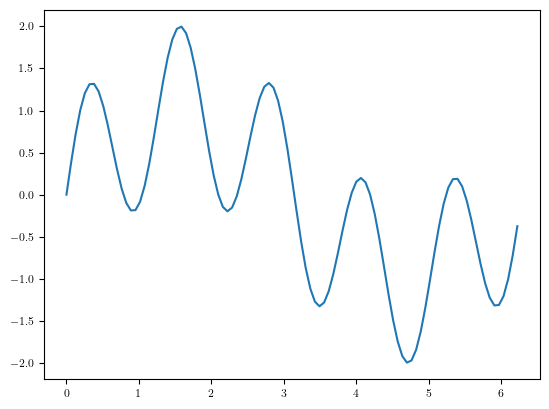

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 8

In [ ]:
plt.scatter(np.real(zs), np.imag(zs))
plt.show()

plt.plot(xs, us)
plt.show()

plt.plot(xs, Hu(xs))
plt.plot(xs, H2(xs))
plt.show()

no roots to left or right


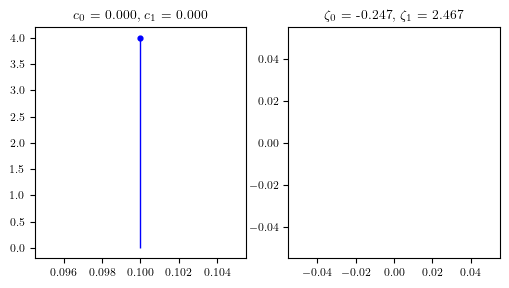

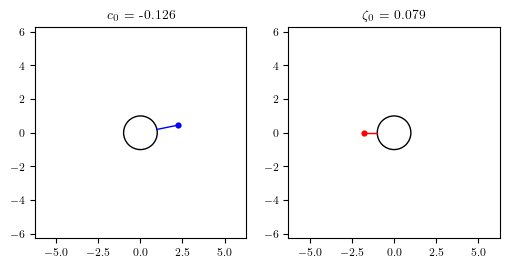

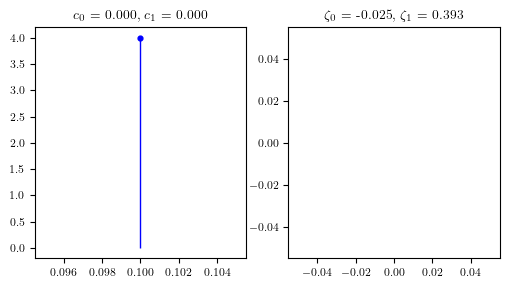

In [86]:
# Define lmbda on real line
quad_pts, quad_wts = trap_quad(-10, 10, 100)
atoms = np.array([0.1])
atom_wts = np.array([4])
lmbda_real = Distribution(None, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=None)
c0_real = 0
c1_real = 0

# Invert lmbda on real line to obtain mu on real line
mu_real, zeta0_real, zeta1_real = B_real(lmbda_real, c0_real, c1_real)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_real, color="blue")
plot_real_distribution(axs[1], mu_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_real:.3f}, $c_1$ = {c1_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_real:.3f}, $\zeta_1$ = {zeta1_real:.3f}")
plt.show()

# Map (lmbda, c0) on real line to (lmbda, c0, c1) on circle
lmbda_circle, c0_circle = psi_real_to_circle(lmbda_real, c0_real, c1_real, 10)

# Invert lmbda on circle to obtain mu on circle
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_circle_distribution(axs[0], lmbda_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
plot_circle_distribution(axs[1], mu_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
plt.show()

# Map lmbda on circle to real line and mu on circle to real line
lmbda_circle_to_real, c0_circle_to_real, c1_circle_to_real = psi_inv_circle_to_real(lmbda_circle, c0_circle, quad_pts, quad_wts)
mu_circle_to_real, zeta0_circle_to_real, zeta1_circle_to_real = psi_inv_circle_to_real(mu_circle, zeta0_circle, quad_pts, quad_wts)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_circle_to_real, color="blue")
plot_real_distribution(axs[1], mu_circle_to_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle_to_real:.3f}, $c_1$ = {c1_circle_to_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle_to_real:.3f}, $\zeta_1$ = {zeta1_circle_to_real:.3f}")
plt.show()

In [87]:
mu_circle.atoms[0] == -np.pi

True

/Users/georgestepaniants/Research/time-deconvolution/hilbert_transform.py:95: RuntimeWarning: divide by zero encountered in divide
  self.H_disc = lambda x: 1/math.pi*np.sum(self.lmbda.atom_wts[None, :] / (x[:, None] - self.lmbda.atoms[None, :]), axis=1)


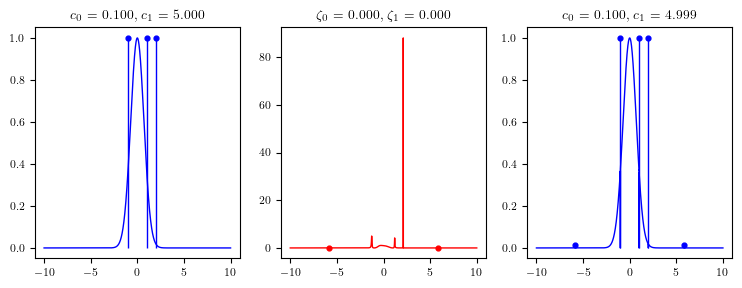

In [114]:
n = 100001
quad_pts, quad_wts = trap_quad(-10, 10, n)
density = lambda x: np.exp(-x**2) #np.ones_like(x)

lmbda_real = Distribution(density, np.array([-1, 1, 2]), np.array([1, 1, 1]), quad_pts, quad_wts)
c0_real = 0.1
c1_real = 5

mu_real, zeta0_real, zeta1_real = B_real(lmbda_real, c0_real, c1_real)

lmbda_real_hat, c0_real_hat, c1_real_hat = B_real(mu_real, zeta0_real, zeta1_real)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plot_real_distribution(axs[0], lmbda_real, color="blue")
plot_real_distribution(axs[1], mu_real, color="red")
plot_real_distribution(axs[2], lmbda_real_hat, color="blue")
axs[0].set_title(f"$c_0$ = {c0_real:.3f}, $c_1$ = {c1_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_real:.3f}, $\zeta_1$ = {zeta1_real:.3f}")
axs[2].set_title(f"$c_0$ = {c0_real_hat:.3f}, $c_1$ = {c1_real_hat:.3f}")
plt.show()

In [113]:
mu_real.zero_sets

array([[   -inf, -5.8768],
       [-5.8768, -5.5024],
       [-1.0002, -0.9998],
       [ 0.9998,  1.0002],
       [ 1.9998,  2.0002],
       [ 2.9998,  3.0002],
       [ 5.504 ,  5.8768],
       [ 5.8768,     inf]])

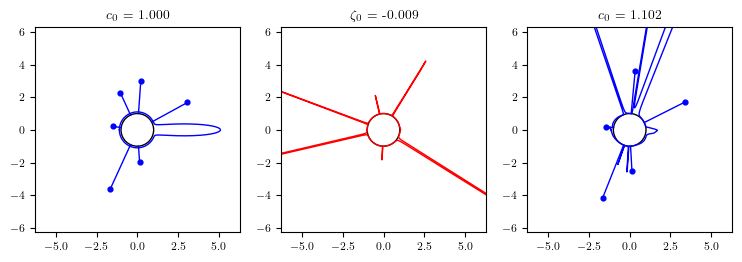

In [15]:
n = 1001
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, n)

sigma = 0.1
density = lambda theta: 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-theta**2/(2*sigma**2)) + 0.1
#density = lambda theta: np.exp(-theta**2)
#density = lambda theta: 1*(np.abs(theta) < 0.6)
#density = lambda theta: np.ones_like(theta)

atoms = np.array([])
atom_wts = np.array([])

atoms = np.array([-2, -1.5, 0.5, 1.5, 2, 3])
atom_wts = np.array([3, 1, 2.5, 2, 1.5, 0.5])

lmbda_circle = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))
c0_circle = 1
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle, thresh=1e-5)

lmbda_circle_hat, c0_circle_hat = B_circle(mu_circle, zeta0_circle)
new_pts = (quad_pts[1:] + quad_pts[:-1])/2
new_wts = quad_wts[1:]
lmbda_circle_hat.update_quadrature(new_pts, new_wts)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plot_circle_distribution(axs[0], lmbda_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
plot_circle_distribution(axs[1], mu_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="red")
plot_circle_distribution(axs[2], lmbda_circle_hat, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
axs[0].set_title(f"$c_0$ = {c0_circle:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
axs[2].set_title(f"$c_0$ = {c0_circle_hat:.3f}")
plt.show()

In [5]:
1/mu_circle.offset_moments(atoms, -2)

array([3. , 1. , 2.5, 2. , 1.5, 0.5])

In [105]:
mu_circle.zero_sets

array([[3.1409644 , 3.14159265],
       [3.14159265, 3.14159265]])

In [91]:
lmbda_circle.atoms

array([-2. , -1.5,  0.5,  1.5,  2. ,  3. ])

In [22]:
np.max(lmbda_circle_hat.density_vals)

2.0077123926152134

In [18]:
np.min(mu_circle.density(new_pts))

1.2960583252001054e-08

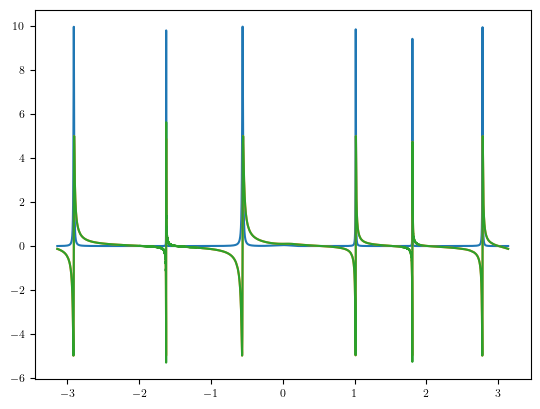

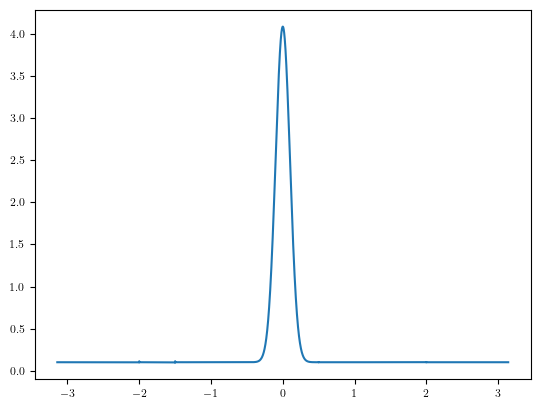

In [10]:
H = HilbertTransform(mu_circle)

plt.plot(quad_pts, mu_circle.density_vals)
plt.plot(quad_pts, H(quad_pts))
plt.plot(quad_pts, np.imag(scipy.signal.hilbert(mu_circle.density_vals)))
#plt.plot(quad_pts, scipy.special.dawsn(quad_pts/(2*sigma))*np.sqrt(sigma/2))
for i in range(mu_circle.zero_sets.shape[0]):
    plt.plot([mu_circle.zero_sets[i, 0], mu_circle.zero_sets[i, 1]], [0, 0], color="black", linewidth=5)
plt.show()

new_pts = quad_pts[1:]*1/4 + quad_pts[:-1]*3/4

plt.plot(new_pts, mu_circle.density(new_pts)/(mu_circle.density(new_pts)**2 + (H(new_pts) + zeta0_circle)**2))
plt.show()

In [4]:
lmbda_circle.moment(0)

6.276908398780808

In [40]:
quad_pts, quad_wts = trap_quad(-np.pi, -np.pi+2*np.pi*(n-1)/n, n)
quad_pts1, quad_wts1 = fourier_quad(-np.pi, np.pi, n)

In [3]:
mu_circle.density_vals

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [18]:
mu_circle.moment(0)

0.7169568003235303

In [19]:
lmbda_circle.moment(0) / (lmbda_circle.moment(0)**2 + c0_circle**2)

0.9900990099009901

In [4]:
H = HilbertTransform(lmbda_circle)

In [34]:
lmbda_circle.zero_sets

array([[-3.14159265,  3.14159265]])

In [29]:
mu_circle.atoms

array([], dtype=float64)

In [17]:
lmbda_circle.zero_sets == np.pi

array([[False, False]])

In [89]:
print(lmbda_circle.atoms)
print(lmbda_circle_hat.atoms)

print(lmbda_circle.atom_wts)
print(lmbda_circle_hat.atom_wts)

[-2.  -1.5  0.5  1.5  2.   3. ]
[]
[3.  1.  2.5 2.  1.5 0.5]
[]


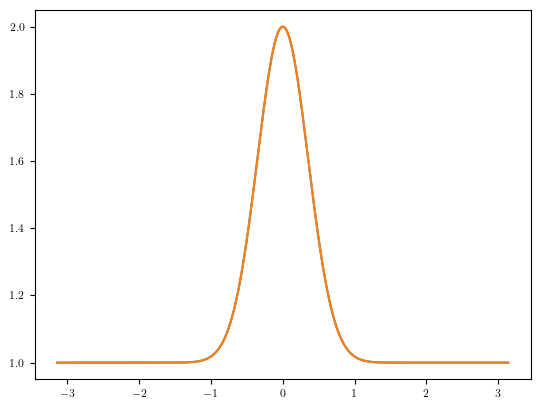

In [88]:
plt.plot(quad_pts, lmbda_circle.density(quad_pts))
plt.plot(quad_pts, lmbda_circle_hat.density(quad_pts))
plt.show()

In [ ]:
np.imag(1/(mu_circle.moment(0) + 1j*zeta0_circle))

In [ ]:
np.imag(1/(2*math.pi + 1j))

In [ ]:
lmbda_circle.moment(0)

In [4]:
H = HilbertTransform(lmbda_circle)

In [ ]:
lmbda_circle.zero_sets

In [ ]:
print(lmbda_circle.atoms)
print(lmbda_circle_hat.atoms)

In [ ]:
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle)

In [ ]:
lmbda.zero_sets

In [ ]:
zeta0_circle != 0 or mu_circle.num_atoms > 0# or (mu_circle.density is not None)

In [94]:
H = lambda x: 1/(2*math.pi) * np.sum(lmbda_circle.atom_wts[None, :] / np.tan((x[:, None] - lmbda_circle.atoms[None, :])/2), axis=1)

In [ ]:
quad_pts == np.pi/2

In [96]:
inds = np.isfinite(H(quad_pts))

In [ ]:
H(quad_pts)

In [ ]:
np.isfinite(H(quad_pts))

In [99]:
inds = np.isfinite(H(quad_pts))

In [ ]:
lmbda_circle.zero_sets

In [ ]:
#H = HilbertTransform(lmbda_circle)

inds = np.isfinite(H(quad_pts))

plt.plot(quad_pts[inds], H(quad_pts[inds]))
plt.show()

In [ ]:
mu_circle.atom_wts

In [4]:
lmbda_real.zero_sets
Hlmbda = HilbertTransform(lmbda_real)

In [ ]:
plt.plot(quad_pts, Hlmbda(quad_pts))
plt.show()

In [ ]:
lmbda_real.atoms

In [ ]:
lmbda_real.zero_sets

In [ ]:
atom_scale = 1
density_scale = 1
width = 2*np.pi

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if lmbda.density is not None:
    axs[0].plot((density_scale*lmbda.density_vals+1)*np.cos(lmbda.quad_pts), (density_scale*lmbda.density_vals+1)*np.sin(lmbda.quad_pts), color="blue")
for i in range(lmbda.num_atoms):
    axs[0].plot(np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.cos(lmbda.atoms[i]), np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.sin(lmbda.atoms[i]), color="blue")
    axs[0].scatter((atom_scale*lmbda.atom_wts[i]+1)*np.cos(lmbda.atoms[i]), (atom_scale*lmbda.atom_wts[i]+1)*np.sin(lmbda.atoms[i]), color="blue")
axs[0].add_patch(circle)
axs[0].set_xlim(-width, width)
axs[0].set_ylim(-width, width)
axs[0].set_aspect('equal')
axs[0].legend()

In [ ]:
mu, zeta0 = B_circle(lmbda, 0.5)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

atom_scale = 1
density_scale = 1
width = 2*np.pi

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if lmbda.density is not None:
    axs[0].plot((density_scale*lmbda.density_vals+1)*np.cos(lmbda.quad_pts), (density_scale*lmbda.density_vals+1)*np.sin(lmbda.quad_pts), color="blue")
for i in range(lmbda.num_atoms):
    axs[0].plot(np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.cos(lmbda.atoms[i]), np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.sin(lmbda.atoms[i]), color="blue")
    axs[0].scatter((atom_scale*lmbda.atom_wts[i]+1)*np.cos(lmbda.atoms[i]), (atom_scale*lmbda.atom_wts[i]+1)*np.sin(lmbda.atoms[i]), color="blue")
axs[0].add_patch(circle)
axs[0].set_xlim(-width, width)
axs[0].set_ylim(-width, width)
axs[0].set_aspect('equal')
axs[0].legend()

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if mu.density is not None:
    axs[1].plot((density_scale*mu.density_vals+1)*np.cos(mu.quad_pts), (density_scale*mu.density_vals+1)*np.sin(mu.quad_pts), color="red")
for i in range(mu.num_atoms):
    axs[1].plot(np.array([1, atom_scale*mu.atom_wts[i]+1])*np.cos(mu.atoms[i]), np.array([1, atom_scale*mu.atom_wts[i]+1])*np.sin(mu.atoms[i]), color="red")
    axs[1].scatter((atom_scale*mu.atom_wts[i]+1)*np.cos(mu.atoms[i]), (atom_scale*mu.atom_wts[i]+1)*np.sin(mu.atoms[i]), color="red")
axs[1].add_patch(circle)
axs[1].set_xlim(-width, width)
axs[1].set_ylim(-width, width)
axs[1].set_aspect('equal')
axs[1].legend()

In [ ]:
plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, fourier_hilbert_transform(lmbda.density_vals, lmbda.quad_pts)(lmbda.quad_pts))
plt.show()

In [ ]:
#plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, Hlmbda(lmbda.quad_pts))
plt.show()

In [ ]:
thetas = 0.9*np.linspace(-math.pi, math.pi, 100)
xs = mobius(thetas)
thetas_hat = mobius_inv(xs)

plt.plot(thetas, xs)
plt.plot(thetas_hat, xs)
plt.show()

In [ ]:
i = -1
c = 1

def func(x):
    return Hlmbda(x) - c

per = lmbda.periodic_domain[1] - lmbda.periodic_domain[0]
func_per = lambda x: func((x - lmbda.periodic_domain[0]) % per)
interval = np.array([lmbda.zero_sets[i, 0]-lmbda.periodic_domain[0], per + lmbda.zero_sets[i, 1]-lmbda.periodic_domain[0]])
root = rescale_rootfind(func_per, interval)

In [ ]:
xs = np.linspace(interval[0], interval[1], 100)
plt.plot(xs, func_per(xs))
plt.scatter(root, func_per(root))
plt.show()

In [ ]:
lmbda.zero_sets

In [ ]:
Hlmbda.roots(c=1)

In [ ]:
plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, Hlmbda(lmbda.quad_pts))
plt.show()

In [ ]:
n = 10
#quad_pts, quad_wts = trap_quad(0, 2*np.pi*(n-1)/n, n)
quad_pts, quad_wts = trap_quad(0, 5*(n-1)/n, n)
sigma = 0.01
density = lambda x: 1/np.sqrt(2*sigma**2)*np.exp(-(x-np.pi)**2/(2*sigma))
atoms = np.array([0, 1, 2])
atom_wts = np.array([1, 2.3, 0.5])
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

assert(np.allclose(np.diff(quad_pts), quad_pts[1] - quad_pts[0]))

thetas = 2*np.pi/5*np.fft.rfftfreq(n)*n
wts = np.fft.rfft(lmbda.density_vals)/n
Hu = 2*np.imag(np.exp(1j*quad_pts[:, None]*thetas)@wts)
Hup = np.imag(scipy.signal.hilbert(lmbda.density_vals))

plt.plot(quad_pts, density(quad_pts))
plt.plot(quad_pts, Hu)
#plt.plot(quad_pts, 1/(2*np.pi)/np.tan((quad_pts - np.pi)/2))
plt.plot(quad_pts, Hup)
plt.show()

In [62]:
n = 10
quad_pts, quad_wts = trap_quad(0, 5*(n-1)/n, n)

In [ ]:
(quad_pts[-1] - quad_pts[0]) * n/(n-1)

In [ ]:
thetas

In [ ]:
quad_pts

In [ ]:
n = 6
#halfpt = int(n/2) if n % 2 == 0 else int((n+1)/2)
#np.fft.rfftfreq(n)*n - np.fft.fftfreq(n)[:halfpt]*n

print(np.fft.fftfreq(n))
print(np.fft.rfftfreq(n))

In [ ]:
np.fft.fft([1, 2, 3, 4, 5])

In [ ]:
np.fft.rfft([1, 2, 3, 4, 5])

In [ ]:
print(np.linalg.norm(Hu - Hup, np.inf))

In [ ]:
plt.plot(thetas, np.real(wts))
plt.plot(thetas, np.imag(wts))
plt.show()

In [ ]:
~np.logical_xor(*np.isfinite((1, np.infty)))

In [ ]:
n = 10001
quad_pts, quad_wts = trap_quad(0, 2*np.pi*(n-1)/n, n)
sigma = 1
density = lambda x: 1/np.sqrt(2*sigma**2)*np.exp(-(x-np.pi)**2/(2*sigma))
atoms = np.array([0, 1, 2], dtype=np.float64)
atom_wts = np.array([1, 2.3, 0.5])
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(0, 2*np.pi))

In [ ]:
lmbda.zero_sets

In [ ]:
quad_pts, quad_wts = trap_quad(-10, 30, 2000)
density_1 = None
atoms_1 = np.array([5, 7, 8.1, 10.3, 12.2, 15])
atom_wts_1 = np.array([1, 2.3, 0.5, 0.7, 2, 0.4])
lmbda_1 = Distribution(None, atoms_1, atom_wts_1, quad_pts, quad_wts)

In [ ]:
lmbda_1.density_vals

In [ ]:
pts = np.concatenate(([-np.inf, -np.inf], [], [np.inf, np.inf]))
vals = np.concatenate(([1, 0], [], [0, 1]))
start_inds = np.where(np.diff((vals == 0).astype(int)) == 1)[0]
end_inds = np.where(np.diff((vals == 0).astype(int)) == -1)[0]+1

In [ ]:
start_inds

In [ ]:
end_inds

In [ ]:
pts